# Importando


In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def ColabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local, nrows=ncolunas)
    return df


In [2]:
drive = '/content/drive/MyDrive/Colab Notebooks/TERA-desafio-3/data/dados_tratados.csv'
local = './data/dados_tratados.csv'

df = ColabOuCode(
    drive,
    local,
    ncolunas=None
)

df.shape    

(6362620, 11)

In [3]:
df.head()

,hora,oldbalanceOrig,origReinc,oldbalanceDest,destReinc,amount,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,6.191112e-06,0,6.191112e-06,0,6.191112e-06,1,0,0,1,0
1,0,1.173007e-06,0,1.173007e-06,0,1.173007e-06,1,0,0,1,0
2,0,1.138854e-07,0,1.138854e-07,0,1.138854e-07,0,0,0,0,1
3,0,1.138854e-07,0,1.138854e-07,0,1.138854e-07,0,1,0,0,0
4,0,7.341607e-06,0,7.341607e-06,0,7.341607e-06,1,0,0,1,0


# Classificações

In [4]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.combine import SMOTEENN

## Separando e balanceando os dados

In [5]:
from sklearn.model_selection import train_test_split

x_df = df.drop('isFraud',axis=1)
y_df = df[['isFraud']]

X_treino, X_teste, y_treino, y_teste = train_test_split(x_df, y_df, test_size=0.3, random_state=42)

In [6]:
sennComb = SMOTEENN(
    sampling_strategy=0.2,
    random_state=42,
    n_jobs=-1
)

X_comb, y_comb = sennComb.fit_resample(X_treino, y_treino)


<AxesSubplot:xlabel='isFraud', ylabel='count'>

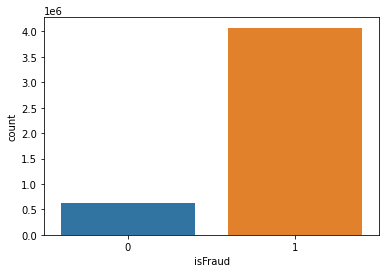

In [7]:
sns.countplot(y_comb['isFraud'])

## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

arvoreDecisao = DecisionTreeClassifier(
    max_depth=8
)
arvoreDecisao.fit(X_comb, y_comb)

y_arvPred = arvoreDecisao.predict(X_teste)

confusion_matrix(y_teste, y_arvPred)


array([[   1918,     517],
       [  27715, 1878636]])

In [9]:
print(classification_report(y_teste, y_arvPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.06      0.79      0.12      2435
  Nao Fraude       1.00      0.99      0.99   1906351

    accuracy                           0.99   1908786
   macro avg       0.53      0.89      0.56   1908786
weighted avg       1.00      0.99      0.99   1908786



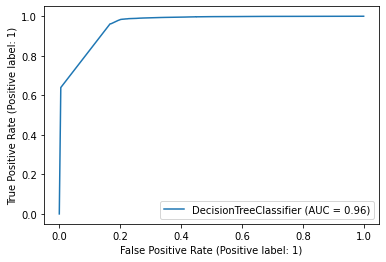

In [10]:
plot_roc_curve(arvoreDecisao, X_teste, y_teste,)
plt.show()

## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(
    n_estimators=10,
    max_depth=13,
)

randForest.fit(X_comb, y_comb)

y_arvRandPred = randForest.predict(X_teste)

confusion_matrix(y_teste, y_arvRandPred)


array([[   25,     6],
       [  153, 14816]])

In [ ]:
print(classification_report(y_teste, y_arvRandPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.14      0.81      0.24        31
  Nao Fraude       1.00      0.99      0.99     14969

    accuracy                           0.99     15000
   macro avg       0.57      0.90      0.62     15000
weighted avg       1.00      0.99      0.99     15000



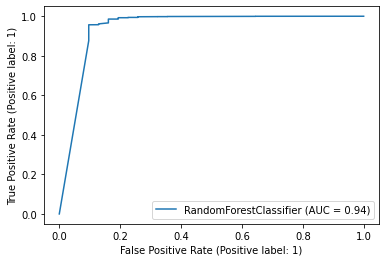

In [ ]:
plot_roc_curve(randForest, X_teste, y_teste,)
plt.show()

## XGBoost

In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=13,
    max_depth=13,
    subsample=0.75,
    #gpu_id='0',
    #tree_method='gpu_hist'

)

xgb.fit(X_comb, y_comb) 
y_xgb = xgb.predict(X_teste)

confusion_matrix(y_teste, y_xgb)

[01:22:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[   1871,     564],
       [  27722, 1878629]])

In [15]:
print(classification_report(y_teste, y_xgb, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.06      0.77      0.12      2435
  Nao Fraude       1.00      0.99      0.99   1906351

    accuracy                           0.99   1908786
   macro avg       0.53      0.88      0.55   1908786
weighted avg       1.00      0.99      0.99   1908786



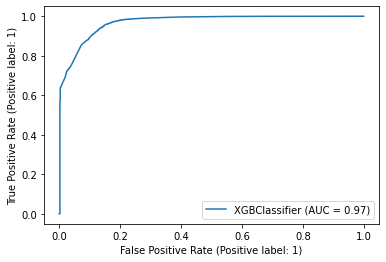

In [16]:
plot_roc_curve(xgb, X_teste, y_teste)
plt.show()